In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.2.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.3.4
numpy 1.19.5
pandas 1.1.5
sklearn 0.24.2
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [2]:
from sklearn import datasets
import tarfile
data_home = datasets.get_data_home()
archive_path = os.path.join(data_home, 'cal_housing.tgz')
with tarfile.open(mode="r:gz", name=archive_path) as f:
     cal_housing = np.loadtxt(
         f.extractfile("CaliforniaHousing/cal_housing.data"), delimiter=","
     )
     # Columns are not in the same order compared to the previous
     # URL resource on lib.stat.cmu.edu
     columns_index = [8, 7, 2, 3, 4, 5, 6, 1, 0]
     cal_housing = cal_housing[:, columns_index]
       
feature_names = [
    "MedInc",
    "HouseAge",
    "AveRooms",
    "AveBedrms",
    "Population",
    "AveOccup",
    "Latitude",
    "Longitude",
]

target, data = cal_housing[:, 0], cal_housing[:, 1:]

# avg rooms = total rooms / households
data[:, 2] /= data[:, 5]

# avg bed rooms = total bed rooms / households
data[:, 3] /= data[:, 5]

# avg occupancy = population / households
data[:, 5] = data[:, 4] / data[:, 5]

# target in units of 100,000
target = target / 100000.0


In [3]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    data,target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)


(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [5]:
# 子类API
#Model类的介绍看下面
# https://tensorflow.google.cn/api_docs/python/tf/keras/Model
#其实就是将原有面向过程的代码，改为面向对象
class WideDeepModel(keras.models.Model):
    def __init__(self):
        super(WideDeepModel, self).__init__()
        """定义模型的层次"""
        self.hidden1_layer = keras.layers.Dense(30, activation='relu')
        self.hidden2_layer = keras.layers.Dense(30, activation='relu')
        self.output_layer = keras.layers.Dense(1)
    
    def call(self, input):
        """完成模型的正向计算"""
        hidden1 = self.hidden1_layer(input)
        hidden2 = self.hidden2_layer(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_layer(concat)
        return output

model = WideDeepModel()
#下面这种也可以，和model = WideDeepModel()是没有打印细节
# model = keras.models.Sequential([
#     WideDeepModel(),
# ])
#build等价于调用call
# model(input_shape=(None, 8))
model.build(input_shape=(None, 8))
        
print(model.summary())
model.compile(loss="mean_squared_error",
              optimizer = keras.optimizers.SGD(0.001))
callbacks = [keras.callbacks.EarlyStopping(
    patience=5, min_delta=1e-2)]

Model: "wide_deep_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  270       
_________________________________________________________________
dense_1 (Dense)              multiple                  930       
_________________________________________________________________
dense_2 (Dense)              multiple                  39        
Total params: 1,239
Trainable params: 1,239
Non-trainable params: 0
_________________________________________________________________
None


In [6]:
history = model.fit(x_train_scaled, y_train,
                    validation_data = (x_valid_scaled, y_valid),
                    epochs = 100,
                    callbacks = callbacks)

Epoch 1/100
363/363 [==============================] - 1s 4ms/step - loss: 1.7228 - val_loss: 0.9028
Epoch 2/100
363/363 [==============================] - 1s 3ms/step - loss: 0.7890 - val_loss: 0.8119
Epoch 3/100
363/363 [==============================] - 1s 3ms/step - loss: 0.7177 - val_loss: 0.7492
Epoch 4/100
363/363 [==============================] - 1s 3ms/step - loss: 0.6651 - val_loss: 0.6995
Epoch 5/100
363/363 [==============================] - 1s 3ms/step - loss: 0.6237 - val_loss: 0.6585
Epoch 6/100
363/363 [==============================] - 1s 3ms/step - loss: 0.5890 - val_loss: 0.6238
Epoch 7/100
363/363 [==============================] - 1s 3ms/step - loss: 0.5632 - val_loss: 0.5943
Epoch 8/100
363/363 [==============================] - 1s 3ms/step - loss: 0.5404 - val_loss: 0.5764
Epoch 9/100
363/363 [==============================] - 1s 3ms/step - loss: 0.5228 - val_loss: 0.5580
Epoch 10/100
363/363 [==============================] - 1s 3ms/step - loss: 0.5095 - val_lo

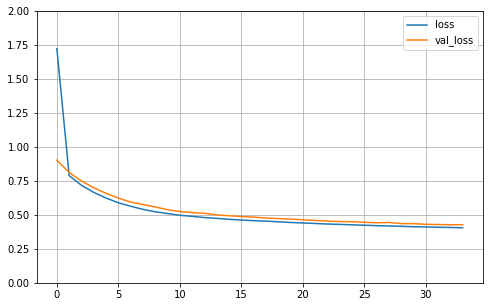

In [7]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 2)
    plt.show()
plot_learning_curves(history)

In [8]:
model.evaluate(x_test_scaled, y_test, verbose=0)

0.42287740111351013